## Obtain the dataset with erddapy

In [1]:
from erddapy import ERDDAP


server = "https://data.pmel.noaa.gov/pmel/erddap"
protocol = "tabledap"
dataset_id = "sd1031_hurricane_2021"

variables = ["latitude", "longitude", "time"]

constraints = {
    "time>=": "now-30days",  # last month
#     or,
#     "time>=": "2021-09-06"
#     "time>=": "2021-10-06"
}

e = ERDDAP(server=server, protocol=protocol)
e.dataset_id = dataset_id
e.variables = variables
e.constraints = constraints

df = e.to_pandas()

## Make the dates a datetime object and make it the index so we can subsample later

In [2]:
import pandas as pd


df["time (UTC)"] = pd.to_datetime(df["time (UTC)"])
df = df.set_index("time (UTC)")
df = df.dropna()

## Subsample to 1 hour and check the data

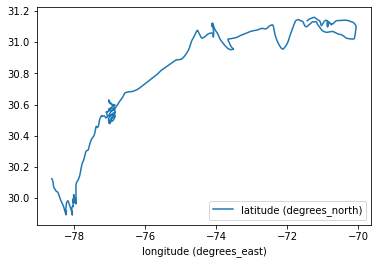

In [3]:
df = df.resample("1H").mean()

df.plot(x="longitude (degrees_east)", y="latitude (degrees_north)");

## Make the linestring with shapely

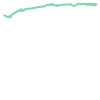

In [4]:
from shapely.geometry import LineString


lon, lat = df["longitude (degrees_east)"], df["latitude (degrees_north)"]
coords = list(zip(lon, lat))
track = LineString(coords)

track

## Quick viz with folium just to check the track

In [5]:
import folium 


m = folium.Map(center=[29.889312, -78.6125376])
gjson = folium.GeoJson(track)
gjson.add_to(m)
m.fit_bounds(gjson.get_bounds())

m

## Save to KML using the dataset_id name

In [6]:
import simplekml


kml = simplekml.Kml()
ls = kml.newlinestring(name=f"{dataset_id}")

ls.coords = coords
kml.save(f"{dataset_id}.kml")

## Round trip test

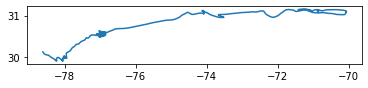

In [7]:
import geopandas


geopandas.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"
gdf = geopandas.read_file(f"{dataset_id}.kml", driver="KML")

gdf["geometry"].plot();